In [1]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import tensorflow as tf

In [2]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D , GlobalAveragePooling2D
from keras import backend as K

from vis.visualization import visualize_cam
import matplotlib.pyplot as plt
import numpy as np

from keras.models import *
from keras.callbacks import *
import keras.backend as K
#from model import *
#from data import *
import cv2
import argparse

batch_size = 128
num_classes = 10
epochs = 100

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

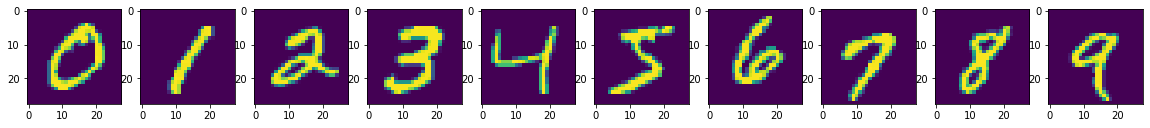

In [4]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(1,10,i+1)
    coord = np.where(y_train.flatten() == i)[0][0]
    plt.imshow(x_train[coord])
    #plt.title(label_list[y_train[coord]])

plt.show()

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="0";  
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
tf.compat.v1.Session(config=config)

In [7]:
model = keras.models.load_model('../models/mnist_cam.h5')

/home/jake/venv/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
def preprocess_input(img):
    #img = pil_image.open(img_path).resize((224, 224))
    img_arr = np.asarray(img)[:, :, :1] / 255.
    img_tensor = np.expand_dims(img_arr, 0)
    
    #print('img_arr->',img_arr.shape,'img_tensor->',img_tensor.shape)
    return img_arr, img_tensor

In [9]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
global_average_pooling2d_8 ( (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                650       
Total params: 38,218
Trainable params: 38,218
Non-trainable params: 0
_________________________________________________________________


In [10]:
def generate_cam(tl_model, img, idx):
    
    ## img_path -> preprocessed image tensor
    #img_arr, img_tensor = preprocess_input(img)
    #img_tensor = np.asarray(img)[:,:,]
    
    img_tensor = img[np.newaxis,...,np.newaxis]/255.
    
    f_k = tl_model.get_layer('conv2d_19').output
    model_input = tl_model.input
    get_output = K.function([model_input],[f_k])
    
    [conv_outputs] = get_output([img_tensor])
    conv_outputs = conv_outputs[0]
    
    #print("conv_outputs->",conv_outputs.shape[0:2])
    
    class_weights = tl_model.layers[-1].get_weights()[0][:, idx]
    #print("class_weights .shape->",class_weights.shape)
    
    ## generate cam
    cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for k, w in enumerate(class_weights):
        #print(cam.shape, k, conv_outputs.shape)
        cam += w * conv_outputs[:, :, k]
        
    cam /= np.max(cam)
    cam = cv2.resize(cam, (28, 28))
    
    #heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    #heatmap[np.where(cam < 0.1)] = 0
    #img_heatmap = heatmap*0.5 + img
    
    img = cv2.resize(img, (28, 28))
    
    #print('grad-cam->', cam.shape,'img_shape->',img.shape)
    
    plt.imshow(cam, cmap="jet")
    plt.imshow(img, cmap="jet", alpha=.5)
    
    return cam,img   
#img_arr ,cam, predictions,img_heatmap = generate_cam(model,original_img,0)

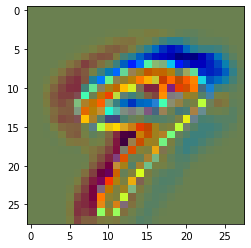

In [11]:
idx = 9
img_heatmap,img = generate_cam(model,x_test[idx],idx)
#plt.imshow(img_heatmap)

In [12]:
label_list = [i for i in range(9)]

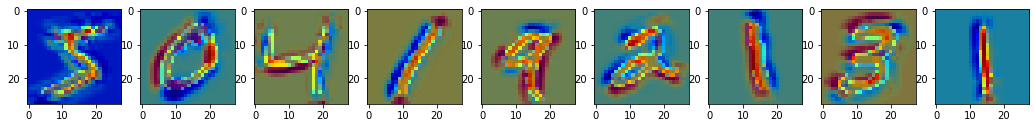

In [13]:
plt.figure(figsize=(20, 20))
for idx in range(9):
    plt.subplot(1,10,idx+1)
    #print(idx)
    coord = np.where(y_train.flatten() == idx)[0][0]
    #plt.imshow(x_train[coord])
    img,grad_cam=generate_cam(model,x_train[idx],idx)
    #plt.title(label_list[y_train[coord]])

#plt.show()

# cifar 10

In [14]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [15]:

label_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [20]:
y_test[0][0]

3

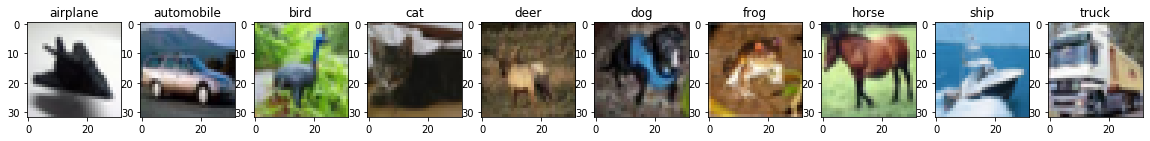

In [22]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(1,10,i+1)
    coord = np.where(y_train.flatten() == i)[0][0]
    plt.imshow(x_train[coord])
    plt.title(label_list[y_train[coord][0]])

plt.show()

In [23]:
model = keras.models.load_model('../models/cifar10')

OSError: Unable to open file (unable to open file: name = '../models/cifar10.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)